# Régression bayésienne

Dans ce notebook, nous allons voir l'application de l'approche bayésienne dans le cas d'une régression linéaire simple. Pour illustrer cette exemple, nous allons utiliser le package `brms`.

Ce package est particulièrememt utile pour deux raisons :

1. Il constitue une interface permettant d’écrire des modèles bayésiens dans le langage `R` en s’appuyant sur la puissance du moteur de calcul de Stan. Stan est un langage de programmation probabiliste permettant d'implémenter les MCMCs pour le calcul de la distribution a posteriori. Il est écrit en `C++` mais peut être utilisé via différentes interfaces, dont `R`, `Python`, et `Matlab`. D'autres outils tels que WinBUGS ou JAGS permettent d'implémenter des MCMCs avec `R` ; Stan a l'avantage de reposer sur une méthode avancée appelée échantillonnage Hamiltonien dynamique qui lui permet de proposer une exploration plus efficace et plus rapide de l'espace des paramètres.

2. Il permet de spécifier des modèles de régression bayésienne de façon intuitive, en utilisant une syntaxe similaire à celle des regressions fréquentistes dont nous avons l'habitude. `brms` permet donc d'utiliser non seulement des modèles linéaires généralisés classiques (par exemple `lm` ou `lme`), mais aussi des modèles linéaires à effets mixtes (aussi appelés modèles hiérarchiques, par exemple `lmer`), tout en profitant de l'efficacité et de la robustesse des algorithmes de `Stan` pour l'estimation. `brms` permet donc de modéliser des stuctures de données plus complexes—par exemple, avec des effets aléatoires pour les individus ou les items—tout en adoptant une approche pleinement bayésienne.

## Quelque aspects techniques avant de commencer

Bien que `bmrs` et `rstan` soient pratiques à utiliser, l'installation peut poser quelques soucis. Le code ci-dessous devrait marcher en principe, mais cela peut prendre un certain temps.

In [8]:
# Installation des packages
install.packages("cmdstanr", repos = c("https://mc-stan.org/r-packages/", getOption("repos")))
install.packages("brms")
install.packages("tidybayes")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

also installing the dependencies ‘quadprog’, ‘svUnit’, ‘ggdist’, ‘arrayhelpers’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [ ]:
# Installer CmdStan en local (nécessite internet, peut durer jusqu'à 10 minutes)
cmdstanr::install_cmdstan(overwrite = TRUE)

In [ ]:
# Vérifier que tout fonctionne
cmdstanr::check_cmdstan_toolchain()
cmdstanr::cmdstan_version()

The C++ toolchain required for CmdStan is setup properly!



[1] "2.36.0"

In [ ]:
# Ne pas afficher les warnings
options(warn = -1)

# Chargement des packages
library(brms)
library(cmdstanr)
library(bayesplot)
library(tidybayes)
library(modelr)

library(tidyverse)
library(ggplot2)

# Fixer la graine aléatoire pour rendre les analyses reproducibles
set.seed(1223)


Attaching package: ‘tidybayes’


The following objects are masked from ‘package:brms’:

    dstudent_t, pstudent_t, qstudent_t, rstudent_t


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


## Création d'un jeu de données simulé

Tout comme dans le premier cours (motivations), nous allons simuler un jeu données afin de pouvoir modifier facilement les caractéristiques de l'étude utilisée en exemple et d'en observer les effets.

Nous allons simuler un jeu de données dans lequel nous mesurons les niveaux d'anxiété-état avec la sous-échelle état du State-Trait Anxiety Questionnaire (STAI-State) et les niveaux socio-économiques de 120 participant-e-x-s. Le niveau socio-économique va de 1 à 20, 1 étant le niveau le plus bas et 20 le niveau le plus élevé. Le niveau d'anxiété-état varie entre 20 et 80, avec des scores au-delà de 50 indiquant une souffrance importante.

Dans le jeu de données que nous allons simuler, nous allons aussi insérer un lien entre les scores d'anxiété et le niveau socio-économique.

In [17]:
# Nombre de participant-e-x-s
n <- 120

# Générer un statut socio-économique entre 1 et 20
socioecon <- rep(0:19, length.out = n)

# Simuler les scores d'anxiété avec une distribution gamma ajustée
base_anxiety <- round(qgamma(ppoints(n), shape = 10, scale = 100))  # Ajustement pour réduire les 20
base_anxiety <- scales::rescale(base_anxiety, to = c(20, 80))

# Générer des scores d’anxiété influencés par le statut socio-économique
anxiety_scores <- round(base_anxiety - socioecon * 2 + rnorm(n, 0, 5))
anxiety_scores <- anxiety_scores + 25
anxiety_scores <- pmax(pmin(anxiety_scores, 80), 20)

# Création du dataset final
simulated_data <- tibble(
  sub_id = 1:n,                   # Identifiant des participant-e-x-s
  socioecon = socioecon,          # Statut socio-économique
  anxiety = anxiety_scores        # Score d'anxiété
)

simulated_data$sub_id <- factor(simulated_data$sub_id)

# Vérification des premières lignes
head(simulated_data)

sub_id,socioecon,anxiety
<fct>,<int>,<dbl>
1,0,50
2,1,48
3,2,50
4,3,49
5,4,40
6,5,46


## Définition des paramètres du GLM

### Priors

Dans notre modèle de régression linéaire simple, nous avons trois paramètres à estimer.

Dans un modèle linéaire généralisé (GLM), nous cherchons à estimer trois paramètres principaux : $\beta_0$ (l'ordonnée à l'origine de la droite), $\beta_1$ (la pente de la droite), et **$\sigma$** (le paramètre de dispersion des données autour de la droite, souvent assimilé à l'écart-type dans le cas d'une distribution normale des erreurs). 

Nous pouvons définir les connaissances a priori que nous avons sur nos trois paramètres du modèle avant même de recueillir les données. Pour cela, il est essentiel de réfléchir à ce que nous savons déjà sur notre variable dépendante. Dans notre cas, il s'agit du STAI-State, un questionnaire mesurant l’anxiété-état. Ce score varie entre 20 (niveau d’anxiété très faible) et 80 (niveau d’anxiété très élevé). La valeur moyenne du STAI-State peut différer selon divers facteurs tels que le genre, l’âge ou encore le pays d’origine. Selon les études, la moyenne peut varier entre 45 et 50 avec des écarts-types assez larges, indiquant une variabilité importante entre les individus. 

#### $\beta_0$

L'intercept représente le niveau d'anxiété-état correspondant au niveau socio-économique le plus bas. Nous pouvons donc imaginer que le niveau d'anxiété-état correspondant au niveau socio-économique le plus bas soit un peu plus élevé que le niveau d'anxiété-état typiquement rapporté dans les études, mais nous allons garder un niveau d'incertitude assez elevé. Nous pouvons modéliser cela avec un distribution normale centrée autour de 50, avec un écart-type de 20 (le double de l'écart-type typique).

Nous pouvons le visualiser de la manière suivante : 

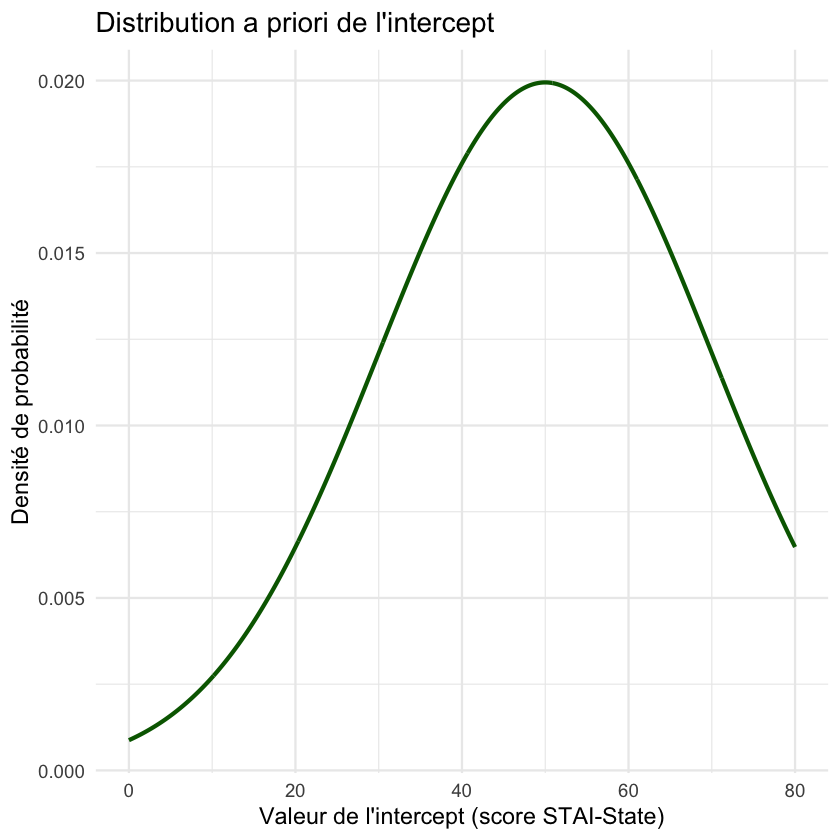

In [ ]:
# Définir l'étendue des valeurs plausibles de l'intercept
x_vals <- seq(0, 80, length.out = 1000)

# Densité de probabilité pour le prior N(50, 20)
prior_density <- dnorm(x_vals, mean = 50, sd = 20)

# Créer la base de données
prior_df <- tibble(
  intercept = x_vals,
  density = prior_density
)

# Faire le graphique
ggplot(prior_df, aes(x = intercept, y = density)) +
  geom_line(color = "darkgreen", size = 1.2) +
  labs(
    title = "Prior de l'intercept",
    x = "Valeur de l'intercept (score STAI-State)",
    y = "Densité de probabilité"
  ) +
  theme_minimal(base_size = 14)

#### $\beta_1$

Le paramètre de pente représente le changement moyen dans le score d'anxiété-état pour une unité de changement de niveau socio-economique. Pour établir le prior de ce paramètre, nous souhaitons conserver un haut niveau d’incertitude quant à la force de l’effet, afin de ne pas contraindre excessivement le modèle. Toutefois, sur la base de connaissances théoriques ou empiriques préalables, nous avons des raisons de penser qu'il est plus probable que l’effet soit négatif que positif. Cela peut par exemple refléter une hypothèse selon laquelle une augmentation de la variable prédictive serait associée à une diminution du score de la variable dépendante. Ainsi, bien que le prior reste relativement large, il est légèrement asymétrique, en faveur de valeurs négatives. Nous pouvons à nouveau utiliser une distribution normale avec une moyenne de -2.5 (legèrement négative) et un écart-type de 5. Nous pouvons le visualiser de la manière suivante, en mettant en valeur les valeurs négatives afin de mieux visualiser l'asymétrie :

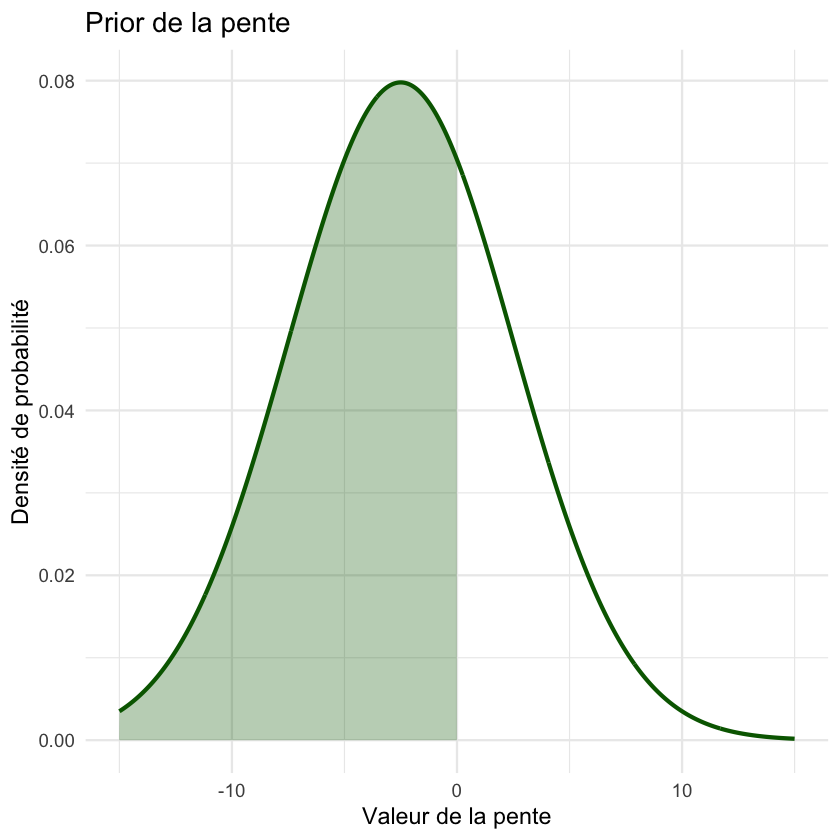

In [19]:
# Définir l'étendue des valeurs plausibles pour la pente
slope_vals <- seq(-15, 15, length.out = 1000)

# Densité de probabilité pour le prior N(-2, 5)
slope_density <- dnorm(slope_vals, mean = -2.5, sd = 5)

# Créer la base de données
slope_df <- tibble(
  slope = slope_vals,
  density = slope_density
)

# Graphique avec zone ombrée pour les pentes négatives
ggplot(slope_df, aes(x = slope, y = density)) +
  geom_line(color = "darkgreen", size = 1.2) +
  geom_area(
    data = subset(slope_df, slope <= 0),
    aes(x = slope, y = density),
    fill = "darkgreen", alpha = 0.3
  ) +
  labs(
    title = "Prior de la pente",
    x = "Valeur de la pente",
    y = "Densité de probabilité"
  ) +
  theme_minimal(base_size = 14)

#### $\sigma$

Ce paramètre représente l’erreur ou la dispersion autour de la prédiction de notre modèle. Nous devons estimer dans quelle mesure les données observées sont susceptibles de s’écarter de la tendance générale. Nous savons que l'échelle du STAI-State varie entre 20 et 80 et que la variance typique (pas dans un modèle de regression) est de 10. Nous savons aussi que $\sigma$ est toujours positif. 

Nous pouvons donc utiliser une distribution gamma (que nous n'avons pas vue en cours) pour déterminer des valeurs positives, avec une incertitude importante, mais en laissant moins de probabilité aux valeurs extrêmes (comme une valeur de 0 ou des valeurs inférieures à 50).

Nous pouvons visualiser cette distribution de la manière suivante :

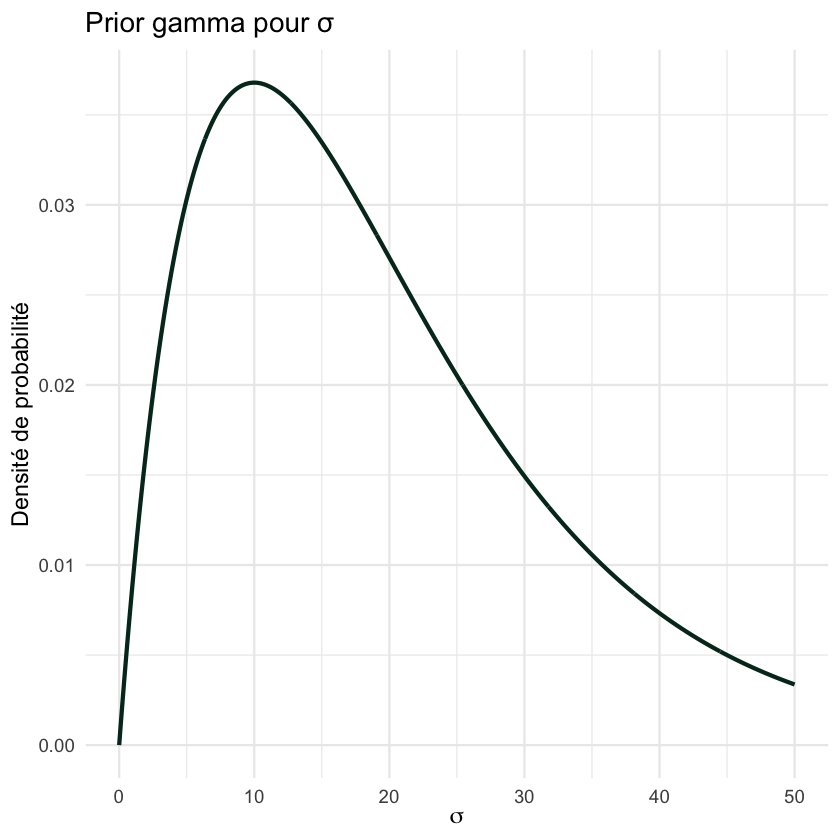

In [20]:
# Définir l'étendue des valeurs plausibles pour sigma
sigma_vals <- seq(0, 50, length.out = 1000)

# Densité de la distribution gamma (2, 0.1)
sigma_density <- dgamma(sigma_vals, shape = 2, rate = 0.1)

# Créer une base de données
sigma_df <- tibble(
  sigma = sigma_vals,
  density = sigma_density
)

# Graphique
ggplot(sigma_df, aes(x = sigma, y = density)) +
  geom_line(color = "#013220", size = 1.2) +
  labs(
    title = "Prior gamma pour σ",
    x = expression(sigma),
    y = "Densité de probabilité"
  ) +
  theme_minimal(base_size = 14)

### MCMC

Les derniers paramètres que nous devons définir concernent le chaines MCMC. Il est essentiel de comprendre plusieurs paramètres de configuration : 

* Le paramètre `niter` correspond au nombre total d’itérations, c’est-à-dire au nombre de pas que chaque chaîne va effectuer pour explorer l’espace des paramètres.
  
* Parmi ces itérations, une partie est réservée au `warmup` : ce sont les premiers pas effectués avant de commencer à enregistrer les échantillons. Ces itérations servent à ajuster l’algorithme (par exemple, à adapter la taille des pas) et sont exclues de l’inférence finale.

* Enfin, le paramètre `chains` correspond au nombre de chaînes indépendantes lancées en parallèle. Chaque chaîne part d’un point différent et permet de vérifier la stabilité et la convergence du modèle. Si les chaînes donnent des résultats similaires malgré des points de départ différents, cela renforce la confiance dans les estimations produites.

In [23]:
# Modèle de régression linéaire bayésien
niter <- 5000
warm <- 1000
chains <- 4
cores <- 4
nsim <- 40000

bglm <- brm(
  anxiety ~ socioecon,
  data = simulated_data,
  family = gaussian,
  priors <- c(
    prior(normal(50, 20), class = "Intercept"),
    prior(normal(-2.5, 5), class = "b", coef = "socioecon"),
    prior(gamma(2, 0.1), class = "sigma")
  ),
  sample_prior = TRUE,
  chains = 4,
  iter = niter,
  warmup = 1000,
  seed = 123,
  backend = "cmdstanr",
  control = list(adapt_delta = 0.99)
)

Start sampling



Running MCMC with 4 sequential chains...

Chain 1 Iteration:    1 / 5000 [  0%]  (Warmup) 
Chain 1 Iteration:  100 / 5000 [  2%]  (Warmup) 
Chain 1 Iteration:  200 / 5000 [  4%]  (Warmup) 
Chain 1 Iteration:  300 / 5000 [  6%]  (Warmup) 
Chain 1 Iteration:  400 / 5000 [  8%]  (Warmup) 
Chain 1 Iteration:  500 / 5000 [ 10%]  (Warmup) 
Chain 1 Iteration:  600 / 5000 [ 12%]  (Warmup) 
Chain 1 Iteration:  700 / 5000 [ 14%]  (Warmup) 
Chain 1 Iteration:  800 / 5000 [ 16%]  (Warmup) 
Chain 1 Iteration:  900 / 5000 [ 18%]  (Warmup) 
Chain 1 Iteration: 1000 / 5000 [ 20%]  (Warmup) 
Chain 1 Iteration: 1001 / 5000 [ 20%]  (Sampling) 
Chain 1 Iteration: 1100 / 5000 [ 22%]  (Sampling) 
Chain 1 Iteration: 1200 / 5000 [ 24%]  (Sampling) 
Chain 1 Iteration: 1300 / 5000 [ 26%]  (Sampling) 
Chain 1 Iteration: 1400 / 5000 [ 28%]  (Sampling) 
Chain 1 Iteration: 1500 / 5000 [ 30%]  (Sampling) 
Chain 1 Iteration: 1600 / 5000 [ 32%]  (Sampling) 
Chain 1 Iteration: 1700 / 5000 [ 34%]  (Sampling) 
Chain 1 Ite

Un résumé des résultats du modèle est présenté ci-dessous. La première chose que vous pouvez observer est que les estimations des paramètres de ce modèle sont congruentes avec le modèle fréquentiste (cf. cours "motivations.ipynb").

In [24]:
# Résumé des résutlats du modèle
summary(bglm)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: anxiety ~ socioecon 
   Data: simulated_data (Number of observations: 120) 
  Draws: 4 chains, each with iter = 5000; warmup = 1000; thin = 1;
         total post-warmup draws = 16000

Regression Coefficients:
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept    62.16      2.00    58.18    66.07 1.00    11636    10072
socioecon    -1.47      0.18    -1.83    -1.11 1.00    11923     9697

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma    11.30      0.74     9.97    12.88 1.00    11899     9772

Draws were sampled using sample(hmc). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).

Pour qu’un modèle bayésien produise des estimations fiables, il est essentiel que les chaînes MCMC aient convergé. Cela signifie que, malgré leurs points de départ différents, les chaînes ont toutes exploré la même région de l’espace des paramètres et échantillonnent à partir de la même distribution a posteriori. Si ce n’est pas le cas, les résultats risquent d’être biaisés ou incohérents.

Pour évaluer cette convergence, on utilise plusieurs outils :

1. Le statistique `Rhat` (dans le tableau ci-dessus) compare la variance entre les chaînes à la variance à l’intérieur de chaque chaîne. Une valeur proche de 1 (généralement < 1.01) indique que les chaînes ont convergé.

2. Les statistiques `Bulk_ESS` et `Tail_ESS` (dans le tableau ci-dessus) se refèrent à l'*effective sample size* (ESS) ou taille d'échantillon effective. Cela indique combien d’échantillons indépendants l’algorithme a effectivement généré, après correction pour l’autocorrélation. Même si nous avons 20 000 échantillons (4 chaînes × 5000 itérations - 1000 warm-ups), l’ESS peut être beaucoup plus faible si nos chaînes sont fortement autocorrélées. Plus l'ESS est élevé, moins les échantillons sont autocorrélés et plus l’estimation est précise. Plus l'ESS est faible, plus l'autocorrélation entre les échantillons est forte, et moins l’inférence est fiable. `Bulk_ESS` correspond au nombre effectif d’échantillons pour l'estimation de la moyenne du paramètre, tandis que `Tail_ESS` correspond au nombre effectif d’échantillons pour l'estimation des queues (extrêmes) de la distribution. Généralement, on cherche à ce que les valeurs de ces deux paramètres soient entre 400 et 1000.

3. Nous pouvons examiner la densité marginale estimée pour chaque chaîne, comme dans le graphique ci-dessous :

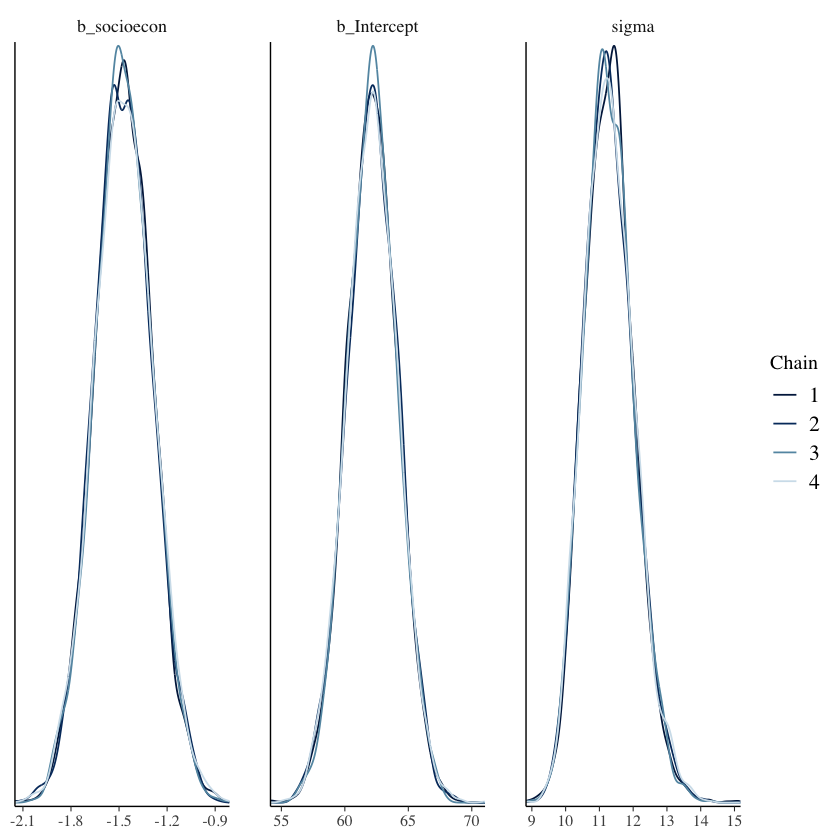

In [25]:
posterior_array <- as.array(bglm)
mcmc_dens_overlay(posterior_array, pars = c("b_socioecon", "b_Intercept", "sigma"))

4. Nous pouvons aussi examiner l’autocorrélation des échantillons, comme dans le graphique ci-dessous. Ce graphique montre à quel point les valeurs successives sont corrélées entre elles à différents lags (décalages). Une faible autocorrélation est souhaitable, car elle signifie que les chaînes explorent efficacement l’espace des paramètres.

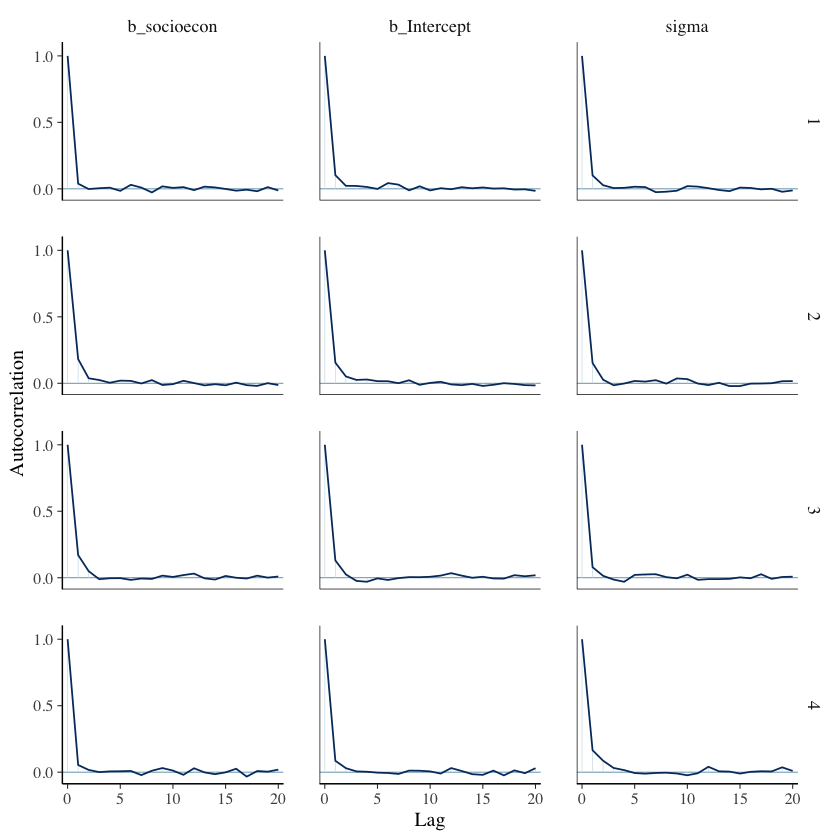

In [26]:
mcmc_acf(posterior_array, pars = c("b_socioecon", "b_Intercept", "sigma"))

5. Le traceplot ci-dessous permet de visualiser l’évolution des échantillons d’un paramètre à travers les itérations, pour chaque chaîne. Si les chaînes semblent "mélangées", sans tendance ou dérive, c’est un bon signe de convergence.

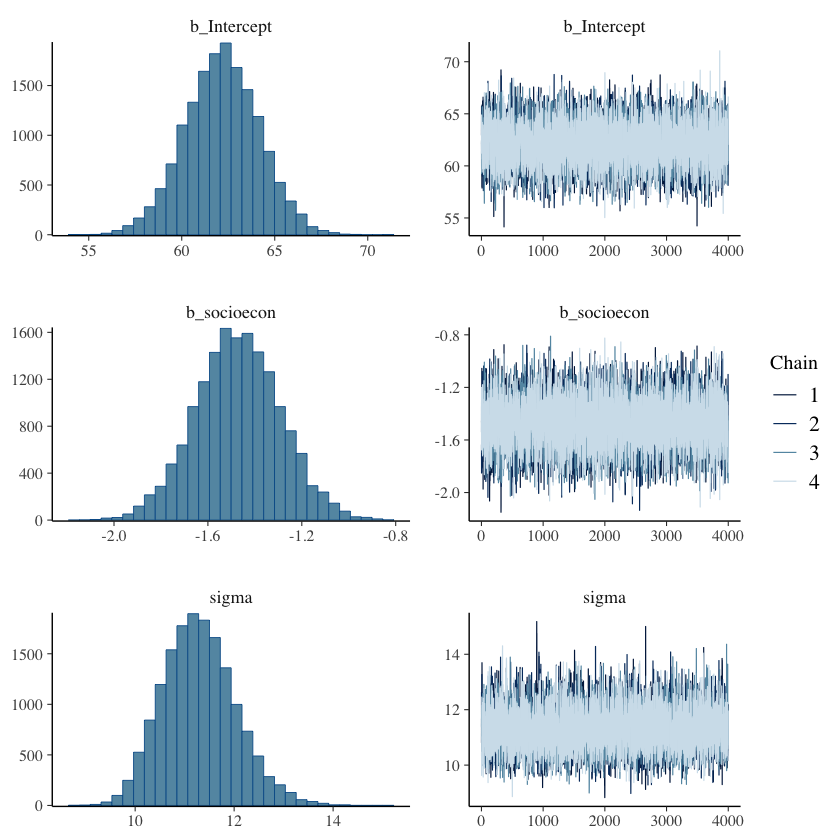

In [27]:
# Graphiques permettant de estimer la fiabilité des résultats
plot(bglm)

Pour avoir une idée de la précision des prédictions du modèle, nous pouvons aussi utiliser la fonction `pp_check`. Dans le graphique ci-dessous nous pouvons voir la distribution des données observées ($y$) et les distributions des données simulées à partir du modèle ajusté $\hat{y}$. Ces prédictions sont multiples (10 dans le cas du graphique ci-dessous), car elles sont générées en tirant des valeurs des paramètres au hasard ($\beta_0$, $\beta_1$, $\sigma$) dans les distributions a posteriori de ces paramètres.

Le graphique ci-dessous montre un très bon ajustement du modèle aux données observées :

Using 10 posterior draws for ppc type 'dens_overlay' by default.



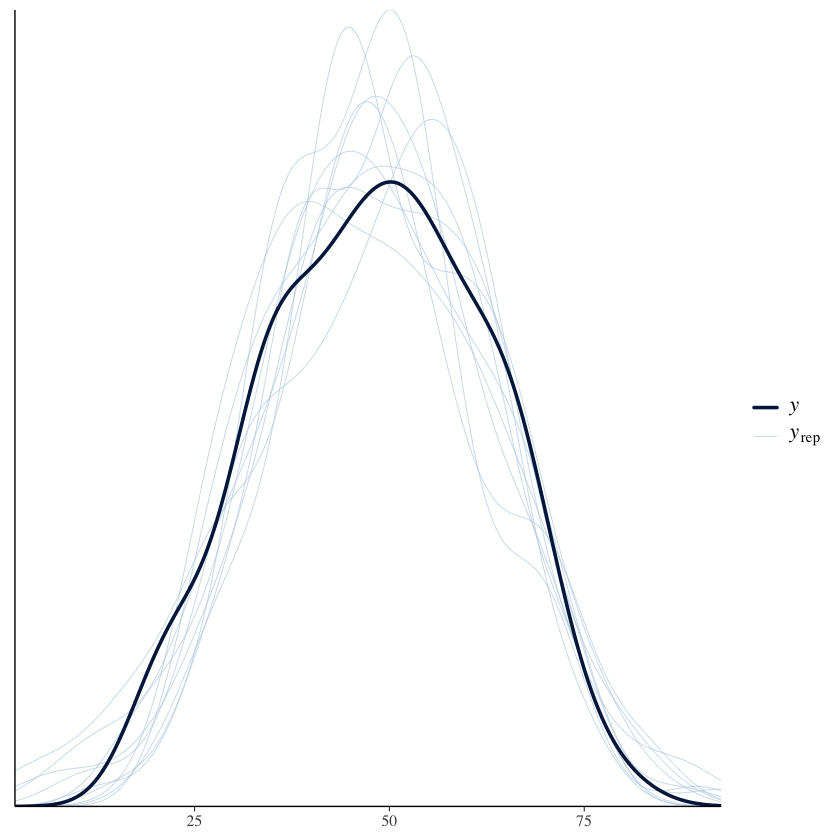

In [28]:
# Ajustement du modèle aux données observées
pp_check(bglm)

Finalement, nous pouvons représenter graphiquement les résultats du modèle de manière plus classique avec les droite de regressions estimées (nous en avons générées 100 ici) comme suit : 

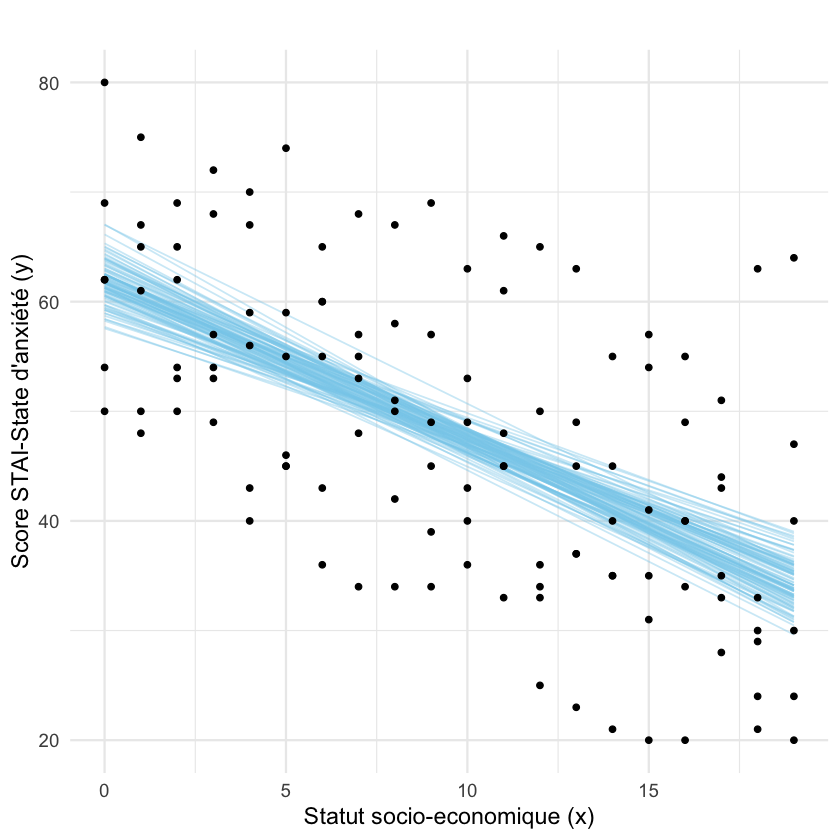

In [29]:
simulated_data %>%
  data_grid(socioecon = seq_range(socioecon, n = 100)) %>%
  add_fitted_draws(bglm, n = 100) %>%
  ggplot(aes(x = socioecon, y = .value)) +
  geom_line(aes(group = .draw), alpha = 0.4, color = "skyblue") +
  geom_point(data = simulated_data, aes(y = anxiety), color = "black", fill = "black", shape = 21) +
  labs(title = "",
       x = "Statut socio-economique (x)",
       y = "Score STAI-State d'anxiété (y)") +
  theme_minimal(base_size = 14)